# Avuzu CTR Models


## Imports

### Import libraries


In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import sklearn.preprocessing as preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
import sklearn.linear_model as linear_model
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
import dask.dataframe as dask_data
from plotly.offline import init_notebook_mode, iplot, plot, download_plotlyjs

In [12]:
plt.style.use('ggplot')

#A parse date variable to pass in the read_csv function later to take into account the date format 
parse_date = lambda val : pd.datetime.strptime(val, '%y%m%d%H')

### Import Data


#### Sampling

In [13]:
''' Specifying a sample of the original training data 
    Training data size == 5.87 gigabytes 
    Number of records === 40428966 (excess of 40 million records)
    
    Using random sampling to select a sample of 1000 records 
'''

import random
n = 40428966  #total number of records in the clickstream data 
sample_size = 10000
skip_values = sorted(random.sample(range(1,n), n-sample_size)) 

#Tracking the indices of rows to be skipped at random in the next stage i.e the LOADING stage 


In [14]:
''' LOADING stage 
    Reading the sampled train data
    Size :1000 records
'''

train_data = pd.read_csv('C:\\Users\\Joseph\\Downloads\\train.csv', parse_dates = ['hour'], date_parser = parse_date,
                        skiprows = skip_values )



In [15]:
'''
Memory optimization at this point ~~ 183 megabytes 

Optimization technique ::: Alter data types from int64 to int32 to reduce block memory usage

Then RELOADING the data 
'''
data_types = {
    'id': np.str,
    'click': np.bool_,
    'hour': np.str,
    'C1': np.uint16,
    'banner_pos': np.uint16,
    'site_id': np.object,
    'site_domain': np.object,
    'site_category': np.object,
    'app_id': np.object,
    'app_domain': np.object,
    'app_category': np.object,
    'device_id': np.object,
    'device_ip': np.object,
    'device_model': np.object,
    'device_type': np.uint16,
    'device_conn_type': np.uint16,
    'C14': np.uint16,
    'C15': np.uint16,
    'C16': np.uint16,
    'C17': np.uint16,
    'C18': np.uint16,
    'C19': np.uint16,
    'C20': np.uint16,
    'C21': np.uint16
}

train_data = pd.read_csv('C:\\Users\\Joseph\\Downloads\\train.csv', parse_dates = ['hour'],
                        date_parser = parse_date, skiprows = skip_values , 
                        dtype = data_types )




In [16]:
train_data_clicks = train_data[train_data['click']==1]

In [17]:
train_data.info() 


## Memory consumption reduced to 107.8 + MB

'''
% reduction in memory usage = 40% 
'''

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001 entries, 0 to 10000
Data columns (total 24 columns):
id                  10001 non-null object
click               10001 non-null bool
hour                10001 non-null datetime64[ns]
C1                  10001 non-null uint16
banner_pos          10001 non-null uint16
site_id             10001 non-null object
site_domain         10001 non-null object
site_category       10001 non-null object
app_id              10001 non-null object
app_domain          10001 non-null object
app_category        10001 non-null object
device_id           10001 non-null object
device_ip           10001 non-null object
device_model        10001 non-null object
device_type         10001 non-null uint16
device_conn_type    10001 non-null uint16
C14                 10001 non-null uint16
C15                 10001 non-null uint16
C16                 10001 non-null uint16
C17                 10001 non-null uint16
C18                 10001 non-null uint16
C19

'\n% reduction in memory usage = 40% \n'

In [18]:
train_data.describe() 

,C1,banner_pos,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
count,10001.000000,10001.000000,10001.000000,10001.000000,10001.000000,10001.000000,10001.000000,10001.000000,10001.000000,10001.000000,10001.000000,10001.000000
mean,1004.972103,0.293071,1.018298,0.338566,18912.963404,319.050895,59.576242,2121.876812,1.408959,230.455054,49008.607839,84.849415
std,1.095957,0.541665,0.531192,0.869345,4939.422554,22.204214,47.218632,606.154921,1.324891,352.206619,15443.908757,70.798056
min,1001.000000,0.000000,0.000000,0.000000,375.000000,120.000000,20.000000,112.000000,0.000000,33.000000,34464.000000,1.000000
25%,1005.000000,0.000000,1.000000,0.000000,17014.000000,320.000000,50.000000,1863.000000,0.000000,35.000000,34548.000000,23.000000
50%,1005.000000,0.000000,1.000000,0.000000,20362.000000,320.000000,50.000000,2331.000000,2.000000,39.000000,34657.000000,61.000000
75%,1005.000000,1.000000,1.000000,0.000000,21957.000000,320.000000,50.000000,2526.000000,3.000000,175.000000,65535.000000,112.000000
max,1012.000000,7.000000,5.000000,5.000000,24041.000000,1024.000000,768.000000,2756.000000,3.000000,1839.000000,65535.000000,253.000000


In [19]:
train_data.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,10181607282627715542,True,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15703,320,50,1722,0,35,34547,79
1,10333438277102444252,False,2014-10-21,1005,0,85f751fd,c4e18dd6,50e219e0,0acbeaa3,45a51db4,...,1,0,20596,320,50,2161,0,35,65535,157
2,10799157821399460819,False,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15706,320,50,1722,0,35,65535,79
3,11890205736895785772,False,2014-10-21,1005,1,43d6df75,27e3c518,28905ebd,ecad2386,7801e8d9,...,1,0,15704,320,50,1722,0,35,65535,79
4,13673909933268978105,False,2014-10-21,1005,0,14c5faa4,30518255,f028772b,ecad2386,7801e8d9,...,1,0,20363,216,36,2333,0,39,65535,157


In [20]:

'''
24 features encompassing site attributes, application features, device attributes 

Target features - click 
>>C14 - C21 - Anonymized categorical variables 

Features kept anonymous via. md5 hashing encrypton : 
  
>>Site features - Site_id, Site_domain, Site_category
>>App features - app_id, app_domain 
>>Device features - device_type, device_conn_type 

'''

train_data.iloc[:, :24].head(5)


,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,10181607282627715542,True,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15703,320,50,1722,0,35,34547,79
1,10333438277102444252,False,2014-10-21,1005,0,85f751fd,c4e18dd6,50e219e0,0acbeaa3,45a51db4,...,1,0,20596,320,50,2161,0,35,65535,157
2,10799157821399460819,False,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15706,320,50,1722,0,35,65535,79
3,11890205736895785772,False,2014-10-21,1005,1,43d6df75,27e3c518,28905ebd,ecad2386,7801e8d9,...,1,0,15704,320,50,1722,0,35,65535,79
4,13673909933268978105,False,2014-10-21,1005,0,14c5faa4,30518255,f028772b,ecad2386,7801e8d9,...,1,0,20363,216,36,2333,0,39,65535,157


'\n'

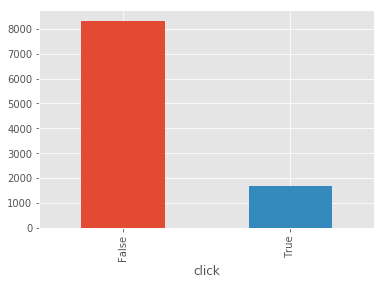

In [21]:
%matplotlib inline

train_data.groupby('click').size().plot(kind = 'bar')
rows = train_data.shape[0]

click_through_rate = train_data['click'].value_counts()/rows 

click_through_rate

'''
'''

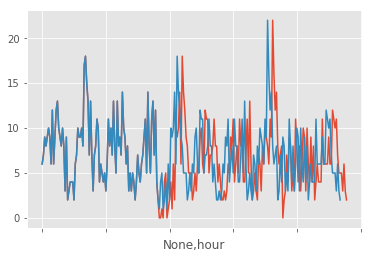

In [22]:
'''
Metric 1. HOUR 
'''

train_data.hour.describe() 


'''INSIGHT 2: Impressions V/S Clicks 
    MAXIMUM number of Impresisons around 1 P.M ~ 1561 '''

df_impressions = train_data.groupby('hour').agg({'click':'sum'})
#df_impressions
df_impressions.unstack().plot()

df_click = train_data[train_data['click']==1]
temp_click = df_click.groupby('hour').agg({'click' : 'sum'})
temp_click.unstack().plot()

#temp_click

In [23]:
train_data.hour.describe()

count                   10001
unique                    240
top       2014-10-28 13:00:00
freq                      122
first     2014-10-21 00:00:00
last      2014-10-30 23:00:00
Name: hour, dtype: object

In [24]:
''' HOUR as a metric is difficult to read because it is a time stamp 
    Introducing new metrics: 
     1. hour_in_day - Better KPI to assess the impressions v/s clicks behavior w.r.t hour in day
     2. weekday -- To study user behavior w.r.t clicks on each day 
     3. Day_name -- To extract the day name from the HOUR feature for a better understanding 
'''

train_data['hour_in_day'] = train_data['hour'].apply(lambda val : val.hour)
train_data_clicks['hour_in_day'] = train_data_clicks['hour'].apply(lambda val : val.hour)

train_data['weekday'] = train_data['hour'].apply(lambda val: val.dayofweek)
train_data_clicks['weekday'] = train_data_clicks['hour'].apply(lambda val: val.dayofweek)

train_data['day_name'] = train_data['hour'].apply(lambda x: x.strftime('%A'))
train_data_clicks['day_name'] = train_data_clicks['hour'].apply(lambda x: x.strftime('%A'))



D:\Users\Joseph\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

D:\Users\Joseph\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

D:\Users\Joseph\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html

In [25]:
train_data.columns

Index(['id', 'click', 'hour', 'C1', 'banner_pos', 'site_id', 'site_domain',
       'site_category', 'app_id', 'app_domain', 'app_category', 'device_id',
       'device_ip', 'device_model', 'device_type', 'device_conn_type', 'C14',
       'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'hour_in_day',
       'weekday', 'day_name'],
      dtype='object')

In [26]:
train_data['hour_in_day'].nunique() #~ 0 TO 23 

24

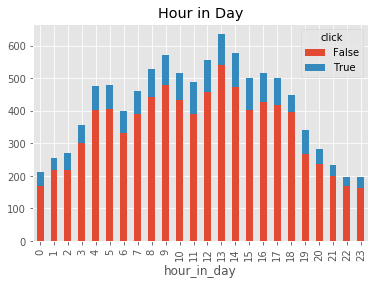

In [27]:
train_data.groupby(['hour_in_day', 'click']).size().unstack().plot(kind='bar', stacked=True, title="Hour in Day")

In [28]:
train_data[['hour','click']].groupby(['hour']).sum().sort_values('click',ascending=False)

,click
hour,
2014-10-28 13:00:00,22.0
2014-10-22 10:00:00,18.0
2014-10-25 14:00:00,18.0
2014-10-22 09:00:00,17.0
2014-10-28 14:00:00,16.0
2014-10-22 11:00:00,15.0
2014-10-24 11:00:00,14.0
2014-10-28 16:00:00,14.0
2014-10-25 12:00:00,14.0


In [29]:
train_data_clicks[['hour','click']].groupby(['hour']).sum().sort_values('click',ascending=False) #do the other way TRUE

,click
hour,
2014-10-28 13:00:00,22.0
2014-10-25 14:00:00,18.0
2014-10-22 10:00:00,18.0
2014-10-22 09:00:00,17.0
2014-10-28 14:00:00,16.0
2014-10-22 11:00:00,15.0
2014-10-25 15:00:00,14.0
2014-10-23 15:00:00,14.0
2014-10-25 12:00:00,14.0


In [30]:
train_data_clicks.head(5)

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,C15,C16,C17,C18,C19,C20,C21,hour_in_day,weekday,day_name
0,10181607282627715542,True,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,320,50,1722,0,35,34547,79,0,1,Tuesday
6,15181624700847922473,True,2014-10-21,1010,1,85f751fd,c4e18dd6,50e219e0,ffc6ffd0,7801e8d9,...,320,50,2493,3,35,65535,117,0,1,Tuesday
15,2358684930032674029,True,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,320,50,1722,0,35,34548,79,0,1,Tuesday
21,5520256235154878145,True,2014-10-21,1005,1,d9750ee7,98572c79,f028772b,ecad2386,7801e8d9,...,320,50,1993,2,1063,65535,33,0,1,Tuesday
23,6235957698912799243,True,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,320,50,1722,0,35,34547,79,0,1,Tuesday


In [31]:
hour_df = pd.DataFrame() 

In [32]:
hour_df['hr'] = train_data_clicks[['hour_in_day','click']].groupby(['hour_in_day']).count().reset_index().sort_values('click',ascending=False)['hour_in_day']
                        
hour_df
#hour_df.drop("hr", axis = 1, inplace = True)

train_data_clicks.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,C15,C16,C17,C18,C19,C20,C21,hour_in_day,weekday,day_name
0,10181607282627715542,True,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,320,50,1722,0,35,34547,79,0,1,Tuesday
6,15181624700847922473,True,2014-10-21,1010,1,85f751fd,c4e18dd6,50e219e0,ffc6ffd0,7801e8d9,...,320,50,2493,3,35,65535,117,0,1,Tuesday
15,2358684930032674029,True,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,320,50,1722,0,35,34548,79,0,1,Tuesday
21,5520256235154878145,True,2014-10-21,1005,1,d9750ee7,98572c79,f028772b,ecad2386,7801e8d9,...,320,50,1993,2,1063,65535,33,0,1,Tuesday
23,6235957698912799243,True,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,320,50,1722,0,35,34547,79,0,1,Tuesday


In [33]:
#Taking into account just the CLICKS 

hour_df['pos_clicks'] = train_data_clicks[['hour_in_day','click']].groupby(['hour_in_day']).count().reset_index().sort_values('click',ascending=False)['click']
            
hour_df

,hr,pos_clicks
14,14,105
11,11,100
12,12,98
15,15,97
13,13,95
9,9,92
16,16,88
8,8,85
17,17,83
10,10,82


In [34]:
#Taking into account the IMPRESSIONS

hour_df['impressions_total'] = train_data[['hour_in_day','click']].groupby(['hour_in_day']).count().reset_index().sort_values('click',ascending=False)['click']
            
hour_df


,hr,pos_clicks,impressions_total
14,14,105,578
11,11,100,489
12,12,98,555
15,15,97,500
13,13,95,636
9,9,92,571
16,16,88,515
8,8,85,527
17,17,83,500
10,10,82,515


In [35]:
#Introducing a new feature click through rate 

hour_df['click_through_rate'] = 100*hour_df['pos_clicks']/hour_df['impressions_total']

hour_df.sort_values(ascending = False, by = 'click_through_rate')


,hr,pos_clicks,impressions_total,click_through_rate
19,19,75,342,21.929825
0,0,45,213,21.126761
11,11,100,489,20.449898
2,2,54,271,19.926199
15,15,97,500,19.400000
14,14,105,578,18.166090
12,12,98,555,17.657658
23,23,34,198,17.171717
16,16,88,515,17.087379
6,6,67,399,16.791980


In [36]:
list_of_hours = hour_df.sort_values(by='click_through_rate',ascending=False)['hr'].tolist()

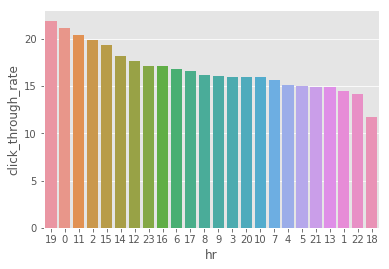

In [37]:
import seaborn as sns
sns.barplot(y='click_through_rate',x='hr'\
            ,data=hour_df\
            ,order=list_of_hours) #nice axis...

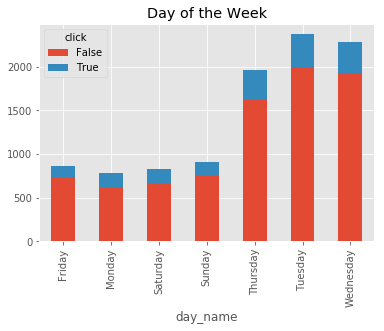

In [38]:
train_data.groupby(['day_name','click']).size().unstack().plot(kind='bar', stacked=True, title="Day of the Week")

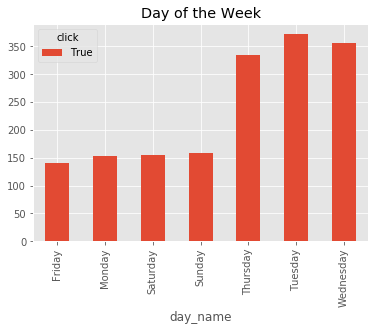

In [39]:
train_data_clicks.groupby(['day_name','click']).size().unstack().plot(kind='bar', stacked=True, title="Day of the Week")

In [40]:
train_data_clicks[['day_name','click']].groupby(['day_name']).count().sort_values('click',ascending=False)

,click
day_name,
Tuesday,372
Wednesday,357
Thursday,334
Sunday,158
Saturday,155
Monday,154
Friday,141


In [41]:
day_df = pd.DataFrame()

In [42]:
day_df['day'] = train_data_clicks[['day_name','click']].groupby(['day_name']).count().reset_index().sort_values('click',ascending=False)['day_name']
day_df 

,day
5,Tuesday
6,Wednesday
4,Thursday
3,Sunday
2,Saturday
1,Monday
0,Friday


In [43]:
day_df['pos_clicks'] = train_data_clicks[['day_name','click']]\
                        .groupby(['day_name']).count()\
                        .reset_index()\
                        .sort_values('click',ascending=False)['click']
day_df

,day,pos_clicks
5,Tuesday,372
6,Wednesday,357
4,Thursday,334
3,Sunday,158
2,Saturday,155
1,Monday,154
0,Friday,141


In [44]:
day_df['total_impressions'] = train_data[['day_name','click']].groupby(['day_name']).count().reset_index().sort_values('click',ascending=False)['click']
day_df

,day,pos_clicks,total_impressions
5,Tuesday,372,2374
6,Wednesday,357,2283
4,Thursday,334,1959
3,Sunday,158,908
2,Saturday,155,829
1,Monday,154,781
0,Friday,141,867


In [45]:
day_df['click_pct'] = 100*day_df['pos_clicks']/day_df['total_impressions']
day_df.sort_values(ascending = False, by = 'click_pct')

,day,pos_clicks,total_impressions,click_pct
1,Monday,154,781,19.718310
2,Saturday,155,829,18.697226
3,Sunday,158,908,17.400881
4,Thursday,334,1959,17.049515
0,Friday,141,867,16.262976
5,Tuesday,372,2374,15.669756
6,Wednesday,357,2283,15.637319


In [46]:
list_of_days = day_df.sort_values(by='click_pct',ascending=False)['day'].tolist()

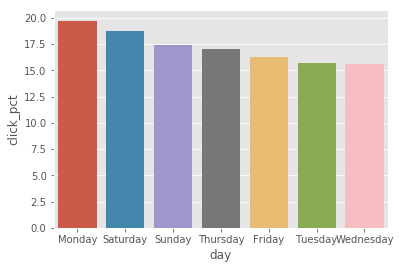

In [47]:
sns.barplot(y='click_pct',x='day'\
            ,data=day_df\
            ,order=list_of_days)

In [48]:
train_data['banner_pos'].unique()

array([0, 1, 5, 7, 2], dtype=uint64)

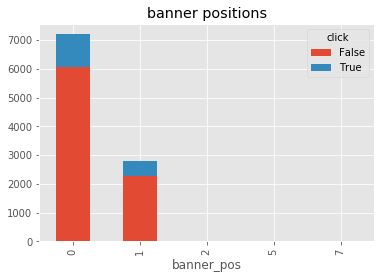

In [49]:
banner_temp =train_data[['banner_pos','click']].groupby(['banner_pos','click'])

banner_temp.size().unstack().plot(kind='bar',stacked=True, title='banner positions')

In [50]:
train_data[['banner_pos','click']].groupby(['banner_pos']).count().sort_values('click',ascending=False)

,click
banner_pos,
0,7195
1,2784
7,20
2,1
5,1


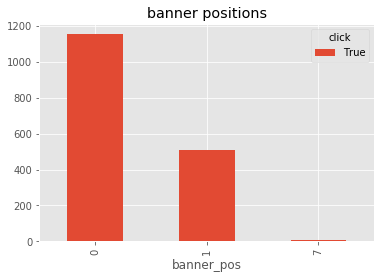

In [51]:
banner_temp =train_data_clicks[['banner_pos','click']].groupby(['banner_pos','click'])

banner_temp.size().unstack().plot(kind='bar',stacked=True, title='banner positions')

In [52]:
train_data_clicks[['banner_pos','click']].groupby(['banner_pos']).count().sort_values('click',ascending=False)

,click
banner_pos,
0,1152
1,510
7,9


In [53]:
import pandas as pd 

banner_df = pd.DataFrame()

In [54]:
banner_df['position'] = train_data_clicks[['banner_pos','click']].groupby(['banner_pos']).count().reset_index().sort_values('click',ascending=False)['banner_pos']

In [55]:
banner_df['pos_clicks'] = train_data_clicks[['banner_pos','click']].groupby(['banner_pos']).count().reset_index().sort_values('click',ascending=False)['click']

In [56]:
banner_df['total_impressions'] = train_data[['banner_pos','click']].groupby(['banner_pos']).count().reset_index().sort_values('click',ascending=False)['click']

In [57]:
banner_df['click_pct'] = 100*banner_df['pos_clicks']/banner_df['total_impressions']

banner_df

,position,pos_clicks,total_impressions,click_pct
0,0,1152,7195,16.011119
1,1,510,2784,18.318966
2,7,9,1,900.000000


In [58]:
banner_df.sort_values(ascending=False,by='click_pct')

,position,pos_clicks,total_impressions,click_pct
2,7,9,1,900.000000
1,1,510,2784,18.318966
0,0,1152,7195,16.011119


In [59]:
list_of_banners = banner_df.sort_values(by='click_pct',ascending=False)['position'].tolist()

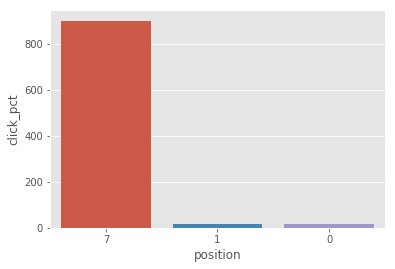

In [60]:
sns.barplot(y='click_pct',x='position'\
            ,data=banner_df\
            ,order=list_of_banners)

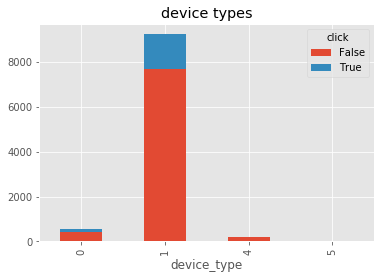

In [61]:
device_temp = train_data[['device_type','click']].groupby(['device_type','click'])

device_temp.size().unstack().plot(kind='bar',stacked=True, title='device types')


In [62]:
train_data[['device_type','click']].groupby(['device_type']).count().sort_values('click',ascending=False)

,click
device_type,
1,9233
0,538
4,199
5,31


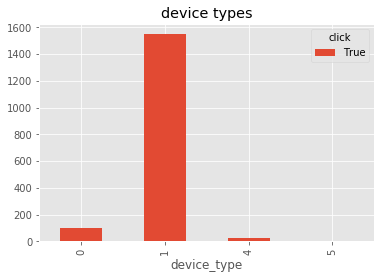

In [63]:
train_data_clicks[['device_type','click']].groupby(['device_type','click']).size().unstack().plot(kind='bar',stacked=True, title='device types')

In [64]:
train_data_clicks[['device_type','click']].groupby(['device_type']).count().sort_values('click',ascending=False)

,click
device_type,
1,1548
0,100
4,22
5,1


In [65]:
device1_df = train_data_clicks[train_data_clicks['device_type']==1]

# extract CLICKS for DEVICE TYPE 1 

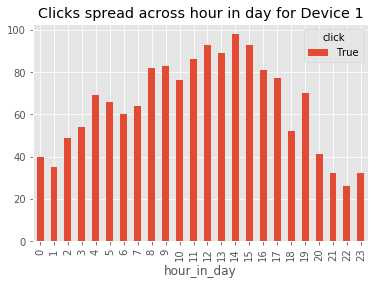

In [66]:
temp_device_df = device1_df.groupby(['hour_in_day', 'click'])

temp_device_df.size().unstack().plot(kind='bar', stacked=True, title="Clicks spread across hour in day for Device 1")

In [67]:
import pandas as pd
dev_type_df=pd.DataFrame()

dev_type_df_total_imp = pd.DataFrame()

In [68]:
#TOTAL CLICKS 

dev_type_df = train_data_clicks.groupby('device_type').agg({'click':'sum'}).reset_index()

dev_type_df

,device_type,click
0,0,100.0
1,1,1548.0
2,4,22.0
3,5,1.0


In [69]:
#TOTAL IMPRESSIONS 

dev_type_df_total_imp = train_data.groupby('device_type').agg({'click':'count'}).reset_index()

In [70]:
#dev_type_df_total_imp.drop([2], inplace = True)

dev_type_df_total_imp

,device_type,click
0,0,538
1,1,9233
2,4,199
3,5,31


In [71]:
dev_type_df['total_impressions'] = dev_type_df_total_imp['click']

dev_type_df

,device_type,click,total_impressions
0,0,100.0,538
1,1,1548.0,9233
2,4,22.0,199
3,5,1.0,31


In [72]:
## sucess percentage == CTR 

dev_type_df['success_pct'] = (dev_type_df['click']/dev_type_df['total_impressions'])*100

dev_type_df

,device_type,click,total_impressions,success_pct
0,0,100.0,538,18.587361
1,1,1548.0,9233,16.765948
2,4,22.0,199,11.055276
3,5,1.0,31,3.225806


In [73]:
dev_type_df_total_imp.columns = ['device_type', 'click2']

merged_df = pd.merge(left = dev_type_df , right = dev_type_df_total_imp,
                    how = 'inner', on = 'device_type')


In [74]:
merged_df

,device_type,click,total_impressions,success_pct,click2
0,0,100.0,538,18.587361,538
1,1,1548.0,9233,16.765948,9233
2,4,22.0,199,11.055276,199
3,5,1.0,31,3.225806,31


In [75]:
merged_df['success_pct'] = 100*(merged_df['click']/merged_df['total_impressions'])

merged_df

,device_type,click,total_impressions,success_pct,click2
0,0,100.0,538,18.587361,538
1,1,1548.0,9233,16.765948,9233
2,4,22.0,199,11.055276,199
3,5,1.0,31,3.225806,31


In [76]:
app_features = ['app_id', 'app_domain', 'app_category']

In [77]:
train_data.groupby('app_category').agg({'click':'sum'}).sort_values(by='click',ascending = False)


,click
app_category,
07d7df22,1247.0
0f2161f8,281.0
f95efa07,61.0
cef3e649,35.0
8ded1f7a,35.0
09481d60,4.0
d1327cf5,3.0
879c24eb,2.0
75d80bbe,1.0


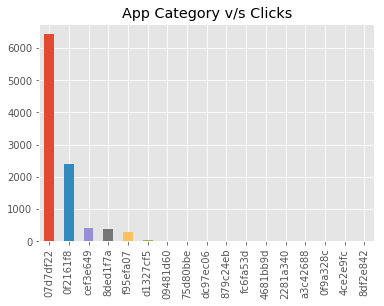

In [78]:
train_data['app_category'].value_counts().plot(kind='bar', title='App Category v/s Clicks')


In [79]:
train_app_category = train_data.groupby(['app_category', 'click']).size().unstack()


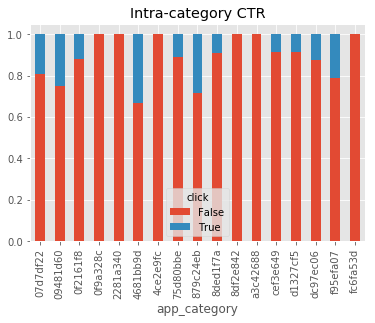

In [80]:

train_app_category.div(train_app_category.sum(axis=1), axis=0).plot(kind='bar', stacked=True, title="Intra-category CTR")

In [81]:

features = ['C1', 'C14', 'C15', 'C16', 'C17', 'C18',
            'C20', 'C21']

train_data[features].astype('object').describe()



,C1,C14,C15,C16,C17,C18,C20,C21
count,10001,10001,10001,10001,10001,10001,10001,10001
unique,7,982,7,8,337,4,126,56
top,1005,4687,320,50,1722,0,65535,23
freq,9188,256,9382,9469,1055,4264,4662,2083


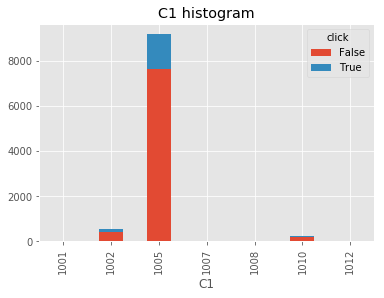

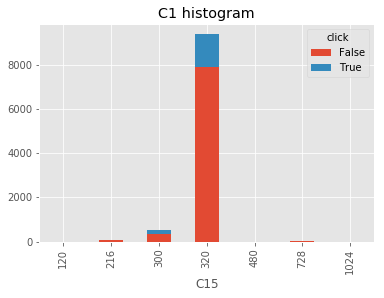

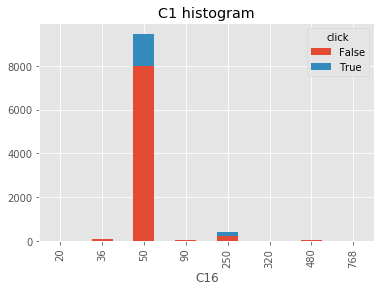

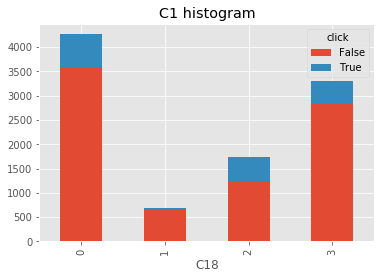

In [82]:
train_data.groupby(['C1', 'click']).size().unstack().plot(kind='bar', stacked=True, title='C1 histogram')
train_data.groupby(['C15', 'click']).size().unstack().plot(kind='bar', stacked=True, title='C1 histogram')
train_data.groupby(['C16', 'click']).size().unstack().plot(kind='bar', stacked=True, title='C1 histogram')
train_data.groupby(['C18', 'click']).size().unstack().plot(kind='bar', stacked=True, title='C1 histogram')


In [83]:
model_features = ['weekday', 'hour_in_day',
                  'banner_pos', 'site_category',
                  'device_conn_type', 'app_category',
                  'device_type']

In [84]:
model_target = 'click'

In [85]:
train_model = train_data[model_features+[model_target]].sample(frac=0.1,random_state=42)

In [86]:
def one_hot_features(data_frame, feature_set):
    new_data_frame = pd.get_dummies(data_frame,
                                     columns = feature_set,
                                    sparse = True)

    return new_data_frame

In [87]:
train_model = one_hot_features(train_model,
                                ['site_category',
                                 'app_category',
                                 'banner_pos'])


In [88]:
train_data.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,C15,C16,C17,C18,C19,C20,C21,hour_in_day,weekday,day_name
0,10181607282627715542,True,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,320,50,1722,0,35,34547,79,0,1,Tuesday
1,10333438277102444252,False,2014-10-21,1005,0,85f751fd,c4e18dd6,50e219e0,0acbeaa3,45a51db4,...,320,50,2161,0,35,65535,157,0,1,Tuesday
2,10799157821399460819,False,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,320,50,1722,0,35,65535,79,0,1,Tuesday
3,11890205736895785772,False,2014-10-21,1005,1,43d6df75,27e3c518,28905ebd,ecad2386,7801e8d9,...,320,50,1722,0,35,65535,79,0,1,Tuesday
4,13673909933268978105,False,2014-10-21,1005,0,14c5faa4,30518255,f028772b,ecad2386,7801e8d9,...,216,36,2333,0,39,65535,157,0,1,Tuesday


In [89]:
df = train_data

In [90]:
def number_encode_features(df):
    result = df.copy()
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object:
            encoders[column] = preprocessing.LabelEncoder()
            result[column] = encoders[column].fit_transform(result[column])
    return result, encoders

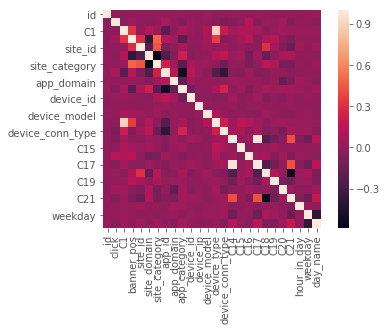

In [91]:
# Calculate the correlation and plot it
encoded_data, _ = number_encode_features(df)
sns.heatmap(encoded_data.corr(), square=True)
plt.show()

In [92]:
encoded_data.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,C15,C16,C17,C18,C19,C20,C21,hour_in_day,weekday,day_name
0,104,True,2014-10-21,1005,0,70,432,1,445,19,...,320,50,1722,0,35,34547,79,0,1,5
1,208,False,2014-10-21,1005,0,299,357,5,24,11,...,320,50,2161,0,35,65535,157,0,1,5
2,497,False,2014-10-21,1005,0,70,432,1,445,19,...,320,50,1722,0,35,65535,79,0,1,5
3,1174,False,2014-10-21,1005,1,149,69,1,445,19,...,320,50,1722,0,35,65535,79,0,1,5
4,2280,False,2014-10-21,1005,0,43,88,15,445,19,...,216,36,2333,0,39,65535,157,0,1,5


In [93]:
encoded_data['hour']=pd.get_dummies(encoded_data['hour'])

In [94]:
ld = encoded_data

In [95]:
ld.describe()

,id,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,...,C15,C16,C17,C18,C19,C20,C21,hour_in_day,weekday,day_name
count,10001.000000,10001.000000,10001.000000,10001.000000,10001.000000,10001.000000,10001.000000,10001.000000,10001.000000,10001.000000,...,10001.000000,10001.000000,10001.000000,10001.000000,10001.000000,10001.000000,10001.000000,10001.000000,10001.000000,10001.000000
mean,5000.000000,0.003200,1004.972103,0.293071,275.031097,305.296170,7.403560,382.866613,18.216578,1.837316,...,319.050895,59.576242,2121.876812,1.408959,230.455054,49008.607839,84.849415,11.296170,2.587541,3.856314
std,2887.184355,0.056478,1.095957,0.541665,139.756618,109.881591,5.477036,116.291511,7.042293,3.763327,...,22.204214,47.218632,606.154921,1.324891,352.206619,15443.908757,70.798056,5.919972,1.716438,1.908521
min,0.000000,0.000000,1001.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,120.000000,20.000000,112.000000,0.000000,33.000000,34464.000000,1.000000,0.000000,0.000000,0.000000
25%,2500.000000,0.000000,1005.000000,0.000000,200.000000,228.000000,3.000000,381.000000,19.000000,0.000000,...,320.000000,50.000000,1863.000000,0.000000,35.000000,34548.000000,23.000000,7.000000,1.000000,3.000000
50%,5000.000000,0.000000,1005.000000,0.000000,299.000000,357.000000,5.000000,445.000000,19.000000,0.000000,...,320.000000,50.000000,2331.000000,2.000000,39.000000,34657.000000,61.000000,11.000000,2.000000,4.000000
75%,7500.000000,0.000000,1005.000000,1.000000,299.000000,357.000000,15.000000,445.000000,19.000000,2.000000,...,320.000000,50.000000,2526.000000,3.000000,175.000000,65535.000000,112.000000,16.000000,4.000000,5.000000
max,10000.000000,1.000000,1012.000000,7.000000,570.000000,457.000000,16.000000,473.000000,41.000000,16.000000,...,1024.000000,768.000000,2756.000000,3.000000,1839.000000,65535.000000,253.000000,23.000000,6.000000,6.000000


In [96]:
target = ld.click

inputs = ld.drop('click', axis=1)

In [97]:
target.head(1)

0    True
Name: click, dtype: bool

In [98]:
inputs.head(1)

,id,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,...,C15,C16,C17,C18,C19,C20,C21,hour_in_day,weekday,day_name
0,104,1,1005,0,70,432,1,445,19,0,...,320,50,1722,0,35,34547,79,0,1,5


In [99]:
from sklearn.model_selection import train_test_split
results = train_test_split(
        inputs,
        target, 
        test_size = 0.2,
        random_state = 42
)

In [100]:
print(type(results))
print(len(results))
print('---')
for item in results:
    print(item.shape)

<class 'list'>
4
---
(8000, 26)
(2001, 26)
(8000,)
(2001,)


In [101]:
# Split your data and pass the results to a new object named "results"

input_train, input_test, target_train, target_test = results
print(input_train.shape)
print(input_test.shape)
print(target_train.shape)
print(target_test.shape)

(8000, 26)
(2001, 26)
(8000,)
(2001,)


In [102]:
from sklearn.linear_model import Lasso, Ridge, LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipelines = {
    'lasso' : make_pipeline(StandardScaler(), Lasso(random_state=1)),
    'ridge' : make_pipeline(StandardScaler(), Ridge(random_state=1))    
}

In [103]:
from sklearn.linear_model import ElasticNet

pipelines['enet'] = make_pipeline(
    StandardScaler(),
    ElasticNet(random_state=1)
)

In [104]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

pipelines['rf'] = make_pipeline(
    StandardScaler(),
    RandomForestRegressor(random_state=1)
)

pipelines['gb'] = make_pipeline(
    StandardScaler(),
    GradientBoostingRegressor(random_state=1)
)

In [105]:
for key, value in pipelines.items():
    print(key, type(value))

lasso <class 'sklearn.pipeline.Pipeline'>
ridge <class 'sklearn.pipeline.Pipeline'>
enet <class 'sklearn.pipeline.Pipeline'>
rf <class 'sklearn.pipeline.Pipeline'>
gb <class 'sklearn.pipeline.Pipeline'>


In [106]:
input_train.head(1)

,id,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,...,C15,C16,C17,C18,C19,C20,C21,hour_in_day,weekday,day_name
1561,8091,0,1005,0,299,357,5,389,6,2,...,320,50,2507,0,35,65535,157,9,2,6


In [107]:
input_test.head(1)

,id,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,...,C15,C16,C17,C18,C19,C20,C21,hour_in_day,weekday,day_name
6252,263,0,1005,0,471,343,15,445,19,0,...,320,50,2316,0,167,34541,16,10,0,1


In [108]:
target_train.head(1)

1561    False
Name: click, dtype: bool

In [109]:
target_test.head(1)

6252    False
Name: click, dtype: bool

### 5. Hyperparameter Tuning

**Lesson Workspace**

In [110]:
# Create a hyperparameter grid for Lasso



lasso_hyperparameters = {
    'lasso__alpha' : [0.01, 0.05, 0.1, 0.5, 1, 5]
    
}



In [111]:
# Create a hyperparameter grid for Ridge

ridge_hyperparameters = { 
    'ridge__alpha' : [0.01, 0.05, 0.1, 0.5, 1, 5] 
}
# Create a hyperparameter grid for Elastic Net

enet_hyperparameters = { 
    'elasticnet__alpha' : [0.01, 0.05, 0.1, 0.5, 1, 5],
    'elasticnet__l1_ratio' : [0.01, 0.3, 0.5, 0.7, .9]
}


In [112]:
# Create a hyperparameter grid for Random Forest



rf_hyperparameters = { 
    'randomforestregressor__n_estimators' : [100, 200] ,
    'randomforestregressor__max_features' : ['auto', 0.3, 0.6]
}

# Create a hyperparameter grid for Gradient Booster

gb_hyperparameters = { 
    'gradientboostingregressor__n_estimators' : [100, 200] ,
    'gradientboostingregressor__learning_rate' : [0.05, 0.1, 0.2],
    'gradientboostingregressor__max_depth' : [1, 3, 5] 
}

**Lesson Workspace**

In [113]:
# Create the hyperparameter_grids dictionary

hyperparameter_grids = {
    'lasso' : lasso_hyperparameters,
    'ridge' : ridge_hyperparameters,
    'enet' : enet_hyperparameters,
    'rf' : rf_hyperparameters,
    'gb' : gb_hyperparameters
}

In [114]:
# Run the code below to make sure everything is set up correctly
for key in ['enet', 'gb', 'ridge', 'rf', 'lasso']:
    if key in hyperparameter_grids:
        if type(hyperparameter_grids[key]) is dict:
            print( key, 'was found, and it is a grid.' )
        else:
            print( key, 'was found, but it is not a grid.' )
    else:
        print( key, 'was not found')

enet was found, and it is a grid.
gb was found, and it is a grid.
ridge was found, and it is a grid.
rf was found, and it is a grid.
lasso was found, and it is a grid.


### 6. Cross Validation

**Lesson Workspace**

In [115]:
# Import GridSearchCV
from sklearn.model_selection import GridSearchCV

In [116]:
untrained_lasso_model = GridSearchCV(
    pipelines['lasso'],
    hyperparameter_grids['lasso'],
    cv=5
)

In [117]:
print(pipelines.keys())
print('---')
print(hyperparameter_grids.keys())

dict_keys(['lasso', 'ridge', 'enet', 'rf', 'gb'])
---
dict_keys(['lasso', 'ridge', 'enet', 'rf', 'gb'])


In [118]:
models = {}

for key in pipelines.keys():
    models[key] = GridSearchCV(
        pipelines[key],
        hyperparameter_grids[key],
        cv=5
    )

models.keys()

dict_keys(['lasso', 'ridge', 'enet', 'rf', 'gb'])

In [119]:
models['lasso'].fit(input_train, target_train)

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Ana

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lasso', Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=1,
   selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'lasso__alpha': [0.01, 0.05, 0.1, 0.5, 1, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [120]:
models['ridge'].fit(input_train, target_train)

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Ana

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Ana

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\sit

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=1, solver='auto', tol=0.001))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'ridge__alpha': [0.01, 0.05, 0.1, 0.5, 1, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [121]:
%time
models['gb'].fit(input_train, target_train)

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.



Wall time: 0 ns


D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('gradientboostingregressor', GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, mi...e=1, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'gradientboostingregressor__n_estimators': [100, 200], 'gradientboostingregressor__learning_rate': [0.05, 0.1, 0.2], 'gradientboostingregressor__max_depth': [1, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [122]:
for key in models.keys():
    models[key].fit(input_train, target_train)
    print(key, 'is trained and tuned.')

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Ana

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib

lasso is trained and tuned.


D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\sit

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\sit

ridge is trained and tuned.


D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\sit

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Ana

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Ana

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Ana

enet is trained and tuned.


D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Ana

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib

rf is trained and tuned.


D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Ana

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib

gb is trained and tuned.


### 7. Selecting a Winning Model

**Lesson Workspace**

In [123]:
# Import the r-squared and mean absolute error metrics

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [124]:
lasso_preds = models['lasso'].predict(input_test)

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.



In [125]:
print('R-Sqaured:', round(r2_score(target_test, lasso_preds),3))
print('MAE:', round(mean_absolute_error(target_test, lasso_preds), 3))
print('MSE:', round(mean_squared_error(target_test, lasso_preds), 3))
print('RMSE:', round(np.sqrt(mean_squared_error(target_test, lasso_preds))))



R-Sqaured: 0.019
MAE: 0.276
MSE: 0.14
RMSE: 0.0


In [126]:
for key in models:
    preds = models[key].predict(input_test)
    print(key)
    print('R-Sqaured:', round(r2_score(target_test, preds), 5))
    print('MAE:', round(mean_absolute_error(target_test, preds),5 ))
    print('MSE:', round(mean_squared_error(target_test, preds), 5))
    print('RMSE:', round(np.sqrt(mean_squared_error(target_test, preds), ),5))
    print('---')

lasso
R-Sqaured: 0.01887
MAE: 0.27622
MSE: 0.14032
RMSE: 0.37459
---
ridge
R-Sqaured: 0.0214
MAE: 0.27347
MSE: 0.13995
RMSE: 0.3741
---
enet
R-Sqaured: 0.0223
MAE: 0.27342
MSE: 0.13983
RMSE: 0.37393
---
rf
R-Sqaured: 0.04766
MAE: 0.26658
MSE: 0.1362
RMSE: 0.36905
---
gb
R-Sqaured: 0.05005
MAE: 0.2663
MSE: 0.13586
RMSE: 0.36859
---


D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.

D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.



D:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning:

Data with input dtype uint8, uint16, int32, int64 were all converted to float64 by StandardScaler.



[]

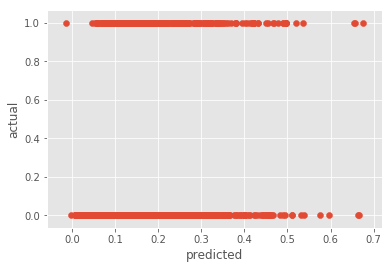

In [127]:
# Make prediction with test data
preds = models['gb'].predict(input_test)

# Plot predictions on x axis and actuals on y axis
plt.scatter(preds, target_test)

# Label axes and show graph
plt.xlabel('predicted')
plt.ylabel('actual')
plt.plot()

